<br/>

$$ \huge{\underline{\textbf{ First Visit MC Prediction }}} $$

<br/>

<center> Implementation of First Visit MC Prediction algorithm from Sutton and Barto 2018, chapter 5.1 </center>

<br/>

<img src="assets/0501_FV_MC_Pred.png"/>

<br/>

In [1]:
def first_visit_MC_prediction(env, policy, ep, gamma):
    """First Visit MC Prediction
    Params:
        env - environment
        policy - function in a form: policy(state)->action
        ep - number of episodes to run
        gamma - discount factor
    """
    V       = dict()
    Returns = defaultdict(list)    # dict of lists
        
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not St in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.average(Returns[St])
    
    return V

Helper functions:

In [2]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0501.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 5.1<center/></td>
    </tr>
</table>

# Alternative Implementation

Slightly more "sane" in my opinion. Also, in environments where state is tuple-of-ints one could use np.array instead of dict for maybe some extra speed.

In [3]:
def first_visit_MC_prediction_2(env, policy, ep, gamma):
    V       = dict()
    Counts  = defaultdict(float)  # Change #1: count number of visits
    Returns = defaultdict(float)  # Change #2: this stores SUM of Returns
        
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not St in [traj[i][0] for i in range(0, t)]:
                Counts[St]  += 1
                Returns[St] += G
    
    # Change #3: do this only once
    for state, returns in Returns.items():
        V[state] = returns / Counts[state]
    
    return V

# Solve Blackjack

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym

Create environment

In [5]:
env = gym.make('Blackjack-v0')

Policy function

In [6]:
def policy(St):
    p_sum, d_card, p_ace = St
    if p_sum >= 20:
        return 0  # stick
    else:
        return 1  # hit

Ploting

In [7]:
def convert_to_arr(V_dict, has_ace):
    V_dict = defaultdict(float, V_dict)  # assume zero if no key
    V_arr = np.zeros([10, 10])  # Need zero-indexed array for plotting 
    
    # convert player sum from 12-21 to 0-9
    # convert dealer card from 1-10 to 0-9
    for ps in range(12, 22):
        for dc in range(1, 11):
            V_arr[ps-12, dc-1] = V_dict[(ps, dc, has_ace)]
    return V_arr

def plot_3d_wireframe(axis, V_dict, has_ace):
    Z = convert_to_arr(V_dict, has_ace)
    dealer_card = list(range(1, 11))
    player_points = list(range(12, 22))
    X, Y = np.meshgrid(dealer_card, player_points)
    axis.plot_wireframe(X, Y, Z)
    
def plot_blackjack(V_dict):
    fig = plt.figure(figsize=[16,3])
    ax_no_ace = fig.add_subplot(121, projection='3d', title='No Ace')
    ax_has_ace = fig.add_subplot(122, projection='3d', title='With Ace')
    ax_no_ace.set_xlabel('Dealer Showing'); ax_no_ace.set_ylabel('Player Sum')
    ax_has_ace.set_xlabel('Dealer Showing'); ax_has_ace.set_ylabel('Player Sum')
    plot_3d_wireframe(ax_no_ace, V_dict, has_ace=False)
    plot_3d_wireframe(ax_has_ace, V_dict, has_ace=True)
    plt.show()

Solve

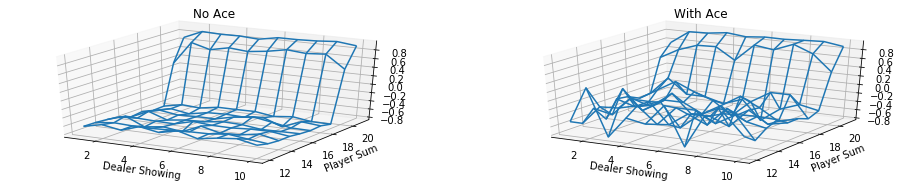

In [8]:
V = first_visit_MC_prediction(env, policy, ep=20000, gamma=1.0)
plot_blackjack(V)

# Recreate Figure 5.1

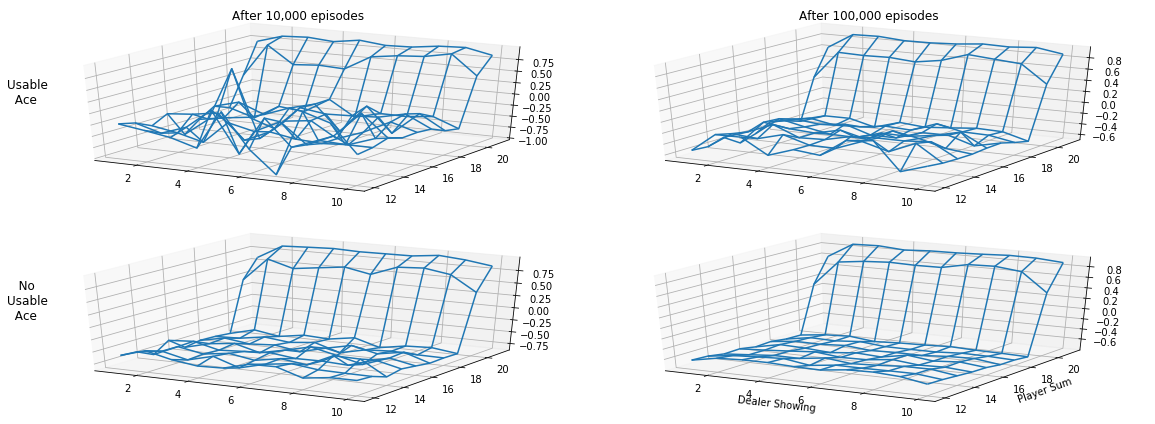

In [9]:
V_10k = first_visit_MC_prediction(env, policy, ep=10000, gamma=1.0)
V_100k = first_visit_MC_prediction(env, policy, ep=100000, gamma=1.0)

fig = plt.figure(figsize=[16,6])
ax_10k_no_ace = fig.add_subplot(223, projection='3d')
ax_10k_has_ace = fig.add_subplot(221, projection='3d', title='After 10,000 episodes')
ax_100k_no_ace = fig.add_subplot(224, projection='3d')
ax_100k_has_ace = fig.add_subplot(222, projection='3d', title='After 100,000 episodes')

fig.text(0., 0.75, 'Usable\n  Ace', fontsize=12)
fig.text(0., 0.25, '   No\nUsable\n  Ace', fontsize=12)

ax_100k_no_ace.set_xlabel('Dealer Showing'); ax_100k_no_ace.set_ylabel('Player Sum')

plot_3d_wireframe(ax_10k_no_ace, V_10k, has_ace=False)
plot_3d_wireframe(ax_10k_has_ace, V_10k, has_ace=True)
plot_3d_wireframe(ax_100k_no_ace, V_100k, has_ace=False)
plot_3d_wireframe(ax_100k_has_ace, V_100k, has_ace=True)

plt.tight_layout()

plt.savefig('assets/fig_0501.png')
plt.show()

# Timing Test

In [10]:
%timeit first_visit_MC_prediction(env, policy, ep=20000, gamma=1.0)
%timeit first_visit_MC_prediction_2(env, policy, ep=20000, gamma=1.0)

1.99 s ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.15 s ± 6.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
